In [1]:
import numpy as np
from PIL import Image
from pathlib import Path
import pandas as pd
from skimage import io
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from skimage.io import imread
from tifffile import imwrite, imsave
import matplotlib as mpl
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
mpl.rcParams['figure.dpi'] = 100
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [2]:
#Read .csv files containing energy, intensity values for reference spectra
metal_ref_data = pd.read_csv("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/Cr_xas_Ledge_metal_reference.csv",header=None,names=("energy","intensity"))
oxide_ref_data = pd.read_csv("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/Cr_xas_Ledge_oxide_reference.csv",header=None,names=("energy","intensity"))

#Prepare data and sort (not necessary if using smooth reference spectra)
metal_ref_data = metal_ref_data.drop_duplicates(subset=["energy"])
metal_ref_data = metal_ref_data.sort_values(by=["energy"])
oxide_ref_data = oxide_ref_data.drop_duplicates(subset=["energy"])
oxide_ref_data = oxide_ref_data.sort_values(by=["energy"])

#Do cubic interpolation on the reference spectra so that any energy/step size can be made compatible with experimental spectra
metal_ref_interp = CubicSpline(metal_ref_data["energy"],metal_ref_data["intensity"])
oxide_ref_interp = CubicSpline(oxide_ref_data["energy"],oxide_ref_data["intensity"])

#Calculate a vector reference spectra with the same start, finish, and step size as the experiment
xrange = np.arange(570,582,0.2)
metal_ref = metal_ref_interp(xrange)
metal_ref = (metal_ref-min(metal_ref))/(max(metal_ref)-min(metal_ref))
oxide_ref = oxide_ref_interp(xrange)
oxide_ref = (oxide_ref-min(oxide_ref))/(max(oxide_ref)-min(oxide_ref))
print(metal_ref.shape)

(60,)


Text(0, 0.5, 'Intensity (arb. u.)')

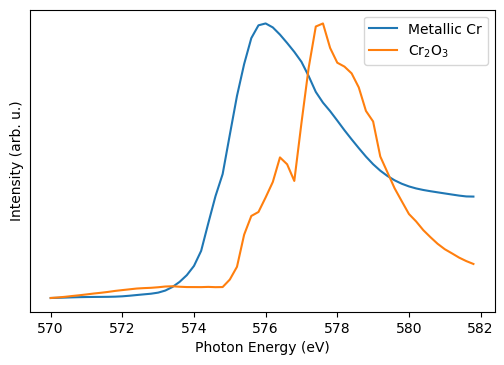

In [3]:
#Visualize the metal and oxide reference spectra
plt.plot(xrange, metal_ref)
plt.plot(xrange, oxide_ref)
plt.legend(("Metallic Cr","$Cr_{2}O_{3}$"))
plt.yticks([])
plt.xlabel("Photon Energy (eV)")
plt.ylabel("Intensity (arb. u.)")

In [4]:
#Read in the hyperspectral image
cr45L = io.imread("/Users/apple/Sync/Research/maxPEEM - Ni-22Cr/3rd_oxidation_45L/normed_45L-Cr XAS 570-595 step0p2.tif")
#Only include the L2 edge, as there's some experimental artifacts in the L3 edge
cr45L = cr45L[:60,:,:]
print(cr45L.shape)

#calculate the straightforward score image, for comparison with PCA (NOT USED)
oxide_score_img = np.dot(cr45L.reshape((len(cr45L),512**2)).T,oxide_ref)
oxide_score_img = oxide_score_img.reshape((512,512))
metal_score_img = np.dot(cr45L.reshape((len(cr45L),512**2)).T,metal_ref)
metal_score_img = metal_score_img.reshape(512,512)
score_sum_img = metal_score_img+oxide_score_img


(60, 512, 512)


In [5]:
#reshape the image into (m x n) where m is observations and n is variables
flat_cr45L = (cr45L.reshape((len(cr45L),512*512)).T)
print(flat_cr45L.shape)
#Take the magnitude of each observation m for use in the cosine calculation
norm = np.linalg.norm(flat_cr45L, axis=1)
print(norm.shape)
#Calculate cosine similarity using CS = a.b/(||a||*||b||)
oxide_cosine = np.dot(flat_cr45L,oxide_ref)/(norm*np.linalg.norm(oxide_ref))
metal_cosine = np.dot(flat_cr45L, metal_ref)/(norm*np.linalg.norm(metal_ref))
#Normalize the total cosine score from 0-1 by adding the oxide and metal scores together
cosine_sum_img = oxide_cosine+metal_cosine
oxide_cosine_norm = oxide_cosine/cosine_sum_img
metal_cosine_norm = metal_cosine/cosine_sum_img

(262144, 60)
(262144,)


<ipython-input-5-743e23cfc71e>:5: RuntimeWarning: invalid value encountered in true_divide
  oxide_cosine = np.dot(flat_cr45L,oxide_ref)/(norm*np.linalg.norm(oxide_ref))
<ipython-input-5-743e23cfc71e>:6: RuntimeWarning: invalid value encountered in true_divide
  metal_cosine = np.dot(flat_cr45L, metal_ref)/(norm*np.linalg.norm(metal_ref))


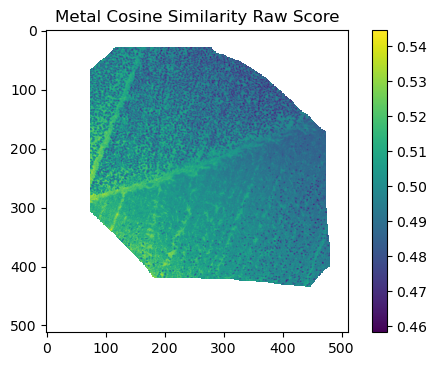

In [6]:
#plot the normalized cosine similarity for metal, and save an image 
plt.imshow(metal_cosine_norm.reshape((512,512)))
plt.title("Metal Cosine Similarity Raw Score")
plt.colorbar()
metal_cosine_img = 32767*np.nan_to_num(metal_cosine_norm.reshape((512,512)))
imsave("metal_cosine_score.tif", metal_cosine_img.astype(np.int16))

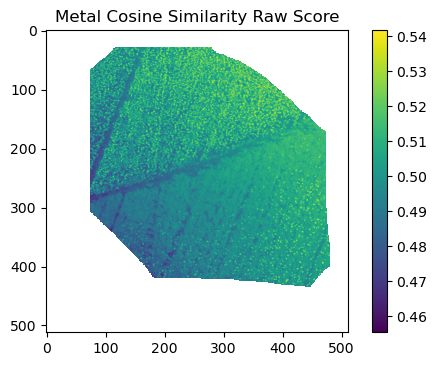

In [7]:
#plot the normalizee cosine similarity for oxide, and save an image
plt.imshow(oxide_cosine_norm.reshape((512,512)))
plt.title("Metal Cosine Similarity Raw Score")
plt.colorbar()
oxide_cosine_img = 32767*np.nan_to_num(oxide_cosine_norm.reshape((512,512)))
imsave("oxide_cosine_score.tif", oxide_cosine_img.astype(np.int16))